<a href="https://colab.research.google.com/github/haileg12/voiceprint-authentication/blob/main/voiceprint_authentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Library and Mounting Drive

In [1]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=25c411880d8165b1139efa061c2500bcc1fc7a4704e012c81a415ad194a0e5f5
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For this program, we will extract features from voice data (.wav files) using MFCC. Additionally, we will use it for model training and develop GMMs for model testing.

In order to get a better undertanding of the program, we tested the program two times with varying amounts of data used for machine learning. **The first time we ran the program, the data we used consisted of 10 speakers (5 female and 5 male). Each speaker has 100 wav files (50 for training and 50 for testing).** The dataset we gathered online was already preprocessed.

Finally, we will use our own voice data (.wav files) to test the program's accuracy.

# Importing Libraries and Packages

In [3]:
# Import necessary packages.
import numpy as np
import os
import pickle
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from python_speech_features import mfcc
from scipy.io.wavfile import read
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# Importing Data

In [4]:
warnings.filterwarnings("ignore")

# Path to dataset for training.
source = "/content/drive/Shareddrives/cs158project/158Project/data/"

# Path to where the Gaussian Mixture Models will be saved.
dest = "/content/drive/Shareddrives/cs158project/158Project/models"

# Path to the text file that decides which audio file will be used for training.
train_file = "/content/drive/Shareddrives/cs158project/158Project/trainingFiles.txt"

file_paths = open(train_file, 'r')

# Visualizing Data

In [5]:
def plot_spectrogram(audio, rate, filename):
    plt.figure(figsize=(10, 4))
    plt.specgram(audio, Fs=rate, NFFT=512, noverlap=256, cmap='viridis')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(filename)
    plt.colorbar().set_label('Intensity (dB)')
    plt.show()

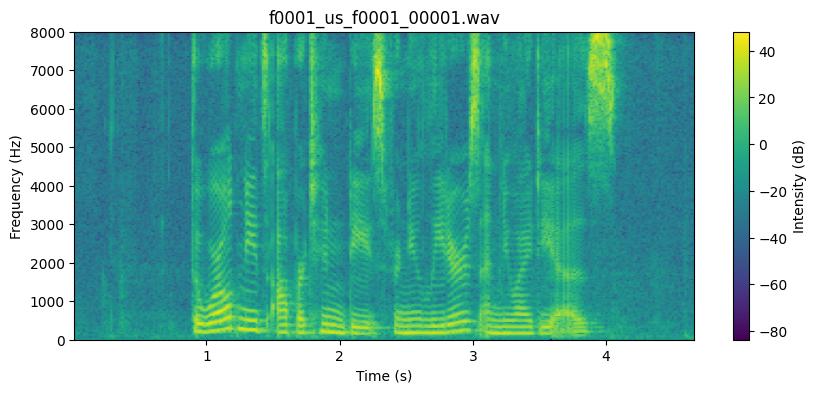

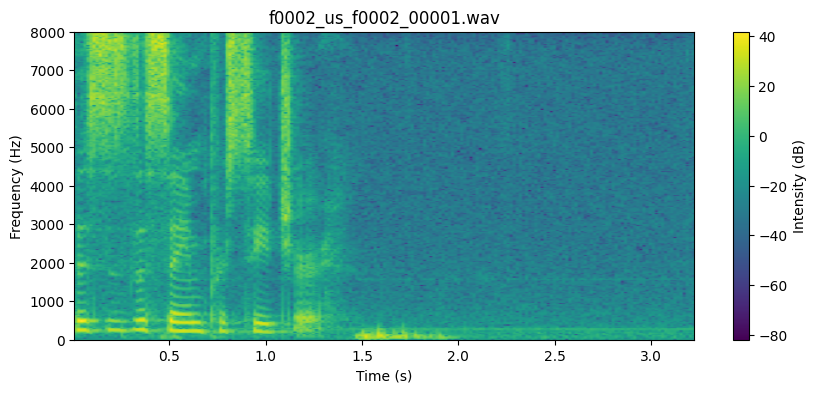

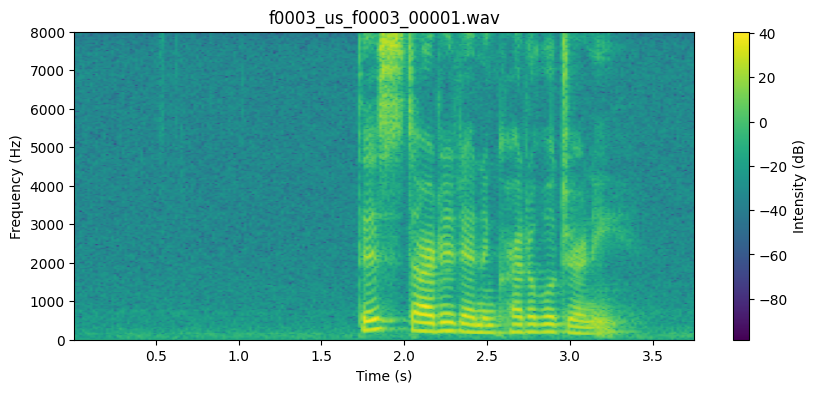

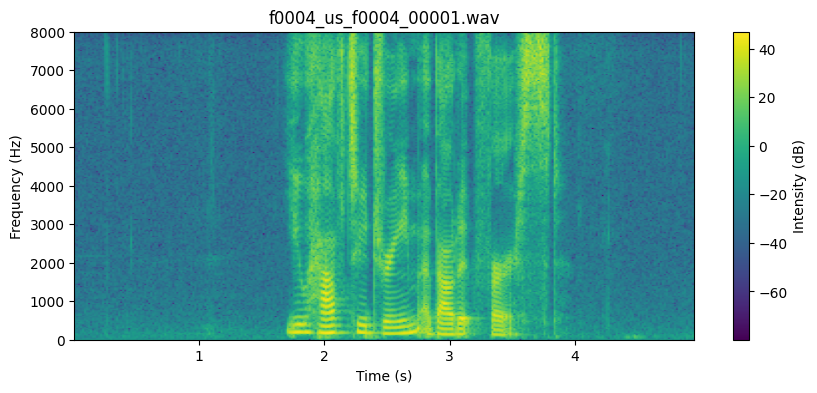

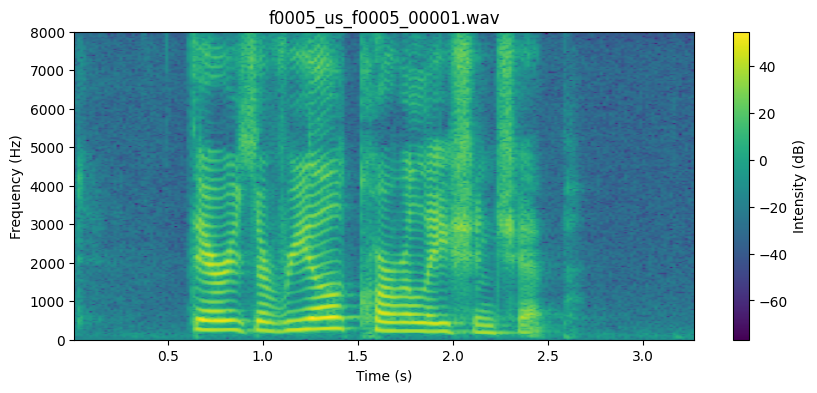

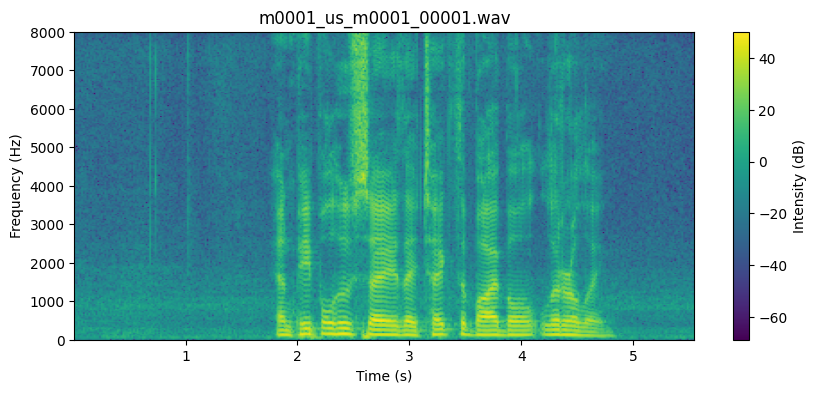

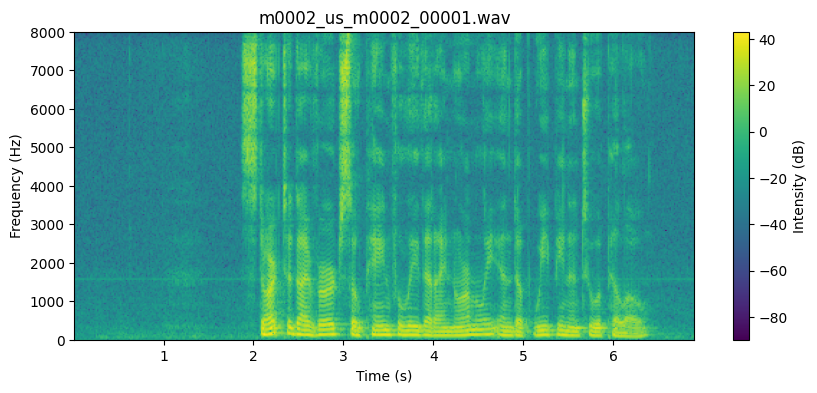

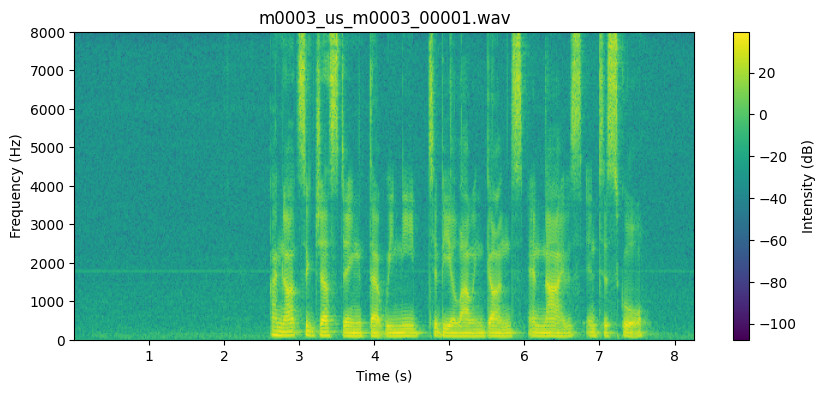

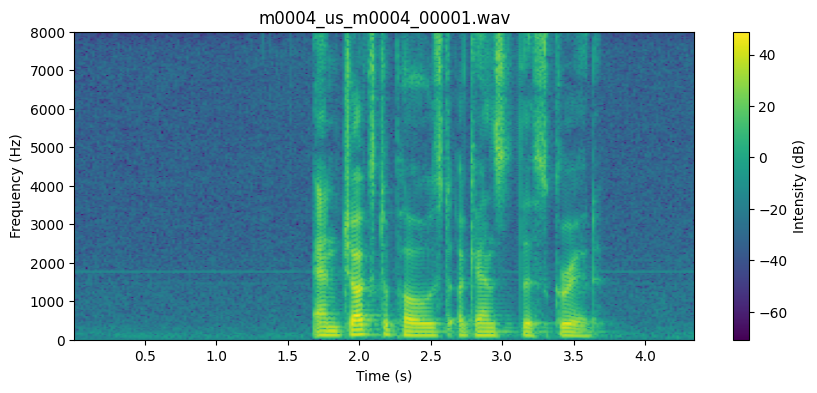

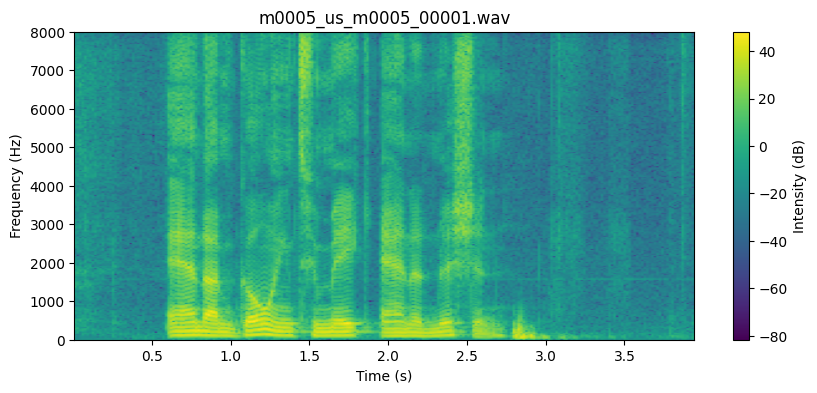

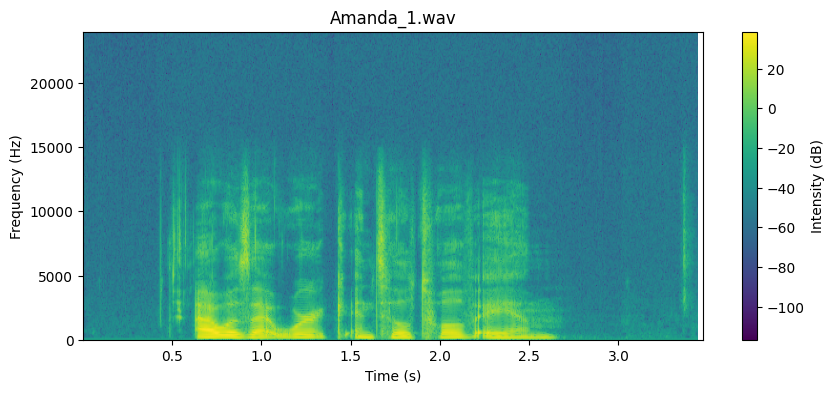

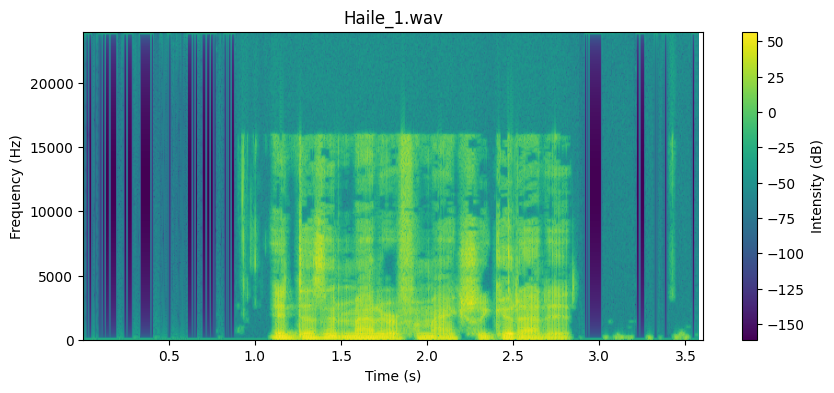

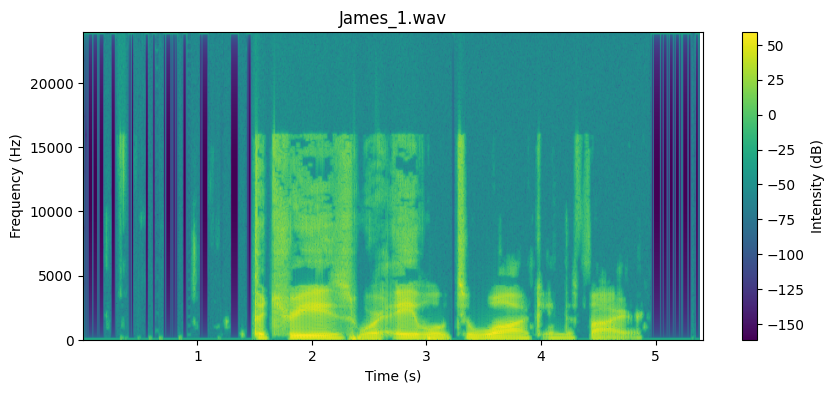

In [6]:
current_speaker = None

with open(train_file, 'r') as file_paths:
    for path in file_paths:
        path = path.strip()

        full_path = os.path.join(source, path)
        # Check if the path is a directory, if so, skip it.
        if os.path.isdir(full_path):
            continue

        # Get speaker name from the file path.
        speaker = path.split("_")[0]

        # Set current_speaker to the first audio file for each speaker class.
        if speaker != current_speaker:
            current_speaker = speaker

            # Read the audio
            sr, audio = read(full_path)

            # Plot the spectrogram with filename as title.
            plot_spectrogram(audio, sr, os.path.basename(path))

# Feature Extraction and Model Training

In [ ]:
def extract_features(audio, rate):
   # Extract 20 dim MFCC features from an audio file, performs CMS and combines delta to make it 40 dim feature vector.
    mfcc_feat = mfcc(audio, rate, winlen=0.025, winstep=0.01, numcep=20, appendEnergy=True, nfft=1200)
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat, delta))
    return combined

In [ ]:
def calculate_delta(array):
    # Calculate and return the delta of given feature vector matrix.
    rows, cols = array.shape
    deltas = np.zeros((rows, 20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i - j < 0:
                first = 0
            else:
                first = i - j
            if i + j > rows - 1:
                second = rows - 1
            else:
                second = i + j
            index.append((second, first))
            j += 1
        deltas[i] = (array[index[0][0]] - array[index[0][1]] +
         (2 * (array[index[1][0]] - array[index[1][1]]))) / 10
    return deltas

In [ ]:
def empty_folder(folder_path):
    # Iterates over all files in the folder.
    for file_name in os.listdir(folder_path):
        # Constructs the full path to the file.
        file_path = os.path.join(folder_path, file_name)
        # Checks if the file is a regular file.
        if os.path.isfile(file_path):
            # Deletes the file.
            os.remove(file_path)

In [ ]:
if __name__ == "__main__":
    print("In main, Call extract_features(audio, signal_rate) as parameters")

In main, Call extract_features(audio, signal_rate) as parameters


In [ ]:
empty_folder(dest) # Ensures the folder is empty first.
current_speaker = None  # Variable to store the current speaker name.
features = np.asarray(())  # Initialize features array.

with open(train_file, 'r') as file_paths:
    for path in file_paths:
        path = path.strip()
        full_path = os.path.join(source, path)  # Full path to the file.

        # Check if the path is a directory, if so, skip it.
        if os.path.isdir(full_path):
            continue

        # Get speaker name from the file path.
        speaker = path.split("_")[0]

        # If the speaker changes or first iteration, train a new model.
        if speaker != current_speaker:
            # If features are available, train the model.
            if features.size > 0:
                gmm = GaussianMixture(n_components=16, max_iter=200, covariance_type='full', n_init=3)
                gmm.fit(features)

                # Dumping the trained Gaussian model
                picklefile = current_speaker + ".gmm"
                with open(os.path.join(dest, picklefile), 'wb') as f:
                    pickle.dump(gmm, f)

                print('+ Modeling completed for speaker:', picklefile, " with data point = ", features.shape)
                features = np.asarray(())

            # Update current speaker.
            current_speaker = speaker

        print(full_path)

        # Read the audio.
        sr, audio = read(full_path)

        # Extract 40 dimensional MFCC & delta MFCC features.
        vector = extract_features(audio, sr)

        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))

    # After processing all files, train the final model if there are remaining features.
    if features.size > 0:
        gmm = GaussianMixture(n_components=16, max_iter=200, covariance_type='full', n_init=3)
        gmm.fit(features)

        # Dumping the trained Gaussian model.
        picklefile = current_speaker + ".gmm"
        with open(os.path.join(dest, picklefile), 'wb') as f:
            pickle.dump(gmm, f)

        print('+ Modeling completed for speaker:', picklefile, " with data point = ", features.shape)

/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00001.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00002.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00003.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00004.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00005.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00006.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00007.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00008.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00009.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00010.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00011.wav
/content/drive/Shareddrives/cs158project/158Project/data/f0001_us_f0001_00012.wav
/content/drive/S

# Testing Model

In [ ]:
# Path to where the Gaussian Mixture Models will be accessed.
modelpath = "/content/drive/Shareddrives/cs158project/158Project/models/"

# Path to the text file that decides which audio file will be used for testing.
test_file = "/content/drive/Shareddrives/cs158project/158Project/testingFiles.txt"

file_paths = open(test_file, 'r')

# Creates a list of GMM files that will be used later for testing.
gmm_files = [os.path.join(modelpath, fname) for fname in os.listdir(modelpath) if fname.endswith('.gmm')]
gmm_files

['/content/drive/Shareddrives/cs158project/158Project/models/f0001.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0002.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0003.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0004.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/f0005.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0001.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0002.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0003.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0004.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/m0005.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/Amanda.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/Haile.gmm',
 '/content/drive/Shareddrives/cs158project/158Project/models/James.gmm']

In [ ]:
# Load the Gaussian Mixture Models.
models = [pickle.load(open(fname, 'rb')) for fname in gmm_files]
models

[GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3),
 GaussianMixture(max_iter=200, n_components=16, n_init=3)]

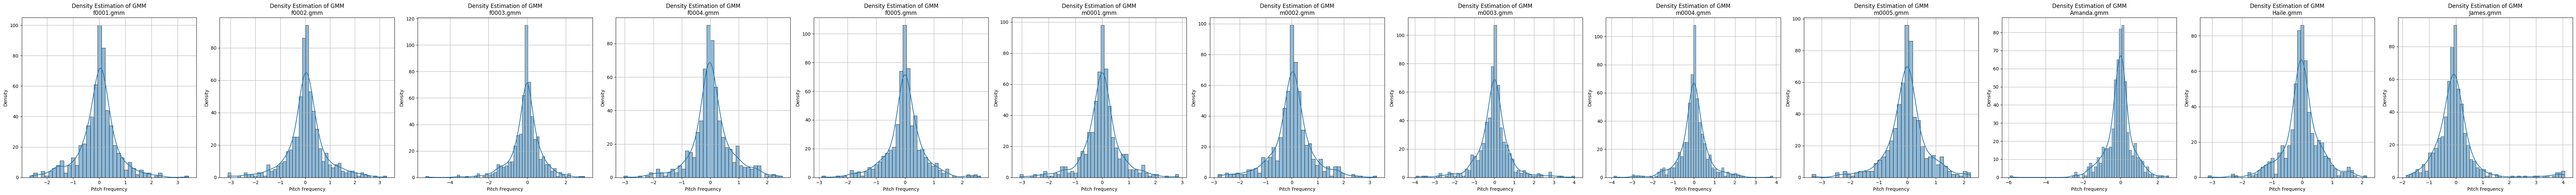

In [ ]:
# Select different dimensions for the feature vectors.
dimensions = [10, 20]

# Create subplots.
num_gmm_files = len(gmm_files)
fig, axes = plt.subplots(1, num_gmm_files, figsize=(6 * num_gmm_files, 6))

# Iterate over each GMM file.
for i, gmm_file in enumerate(gmm_files):

    # Load the Gaussian mixture model.
    gmm_model = pickle.load(open(os.path.join(modelpath, gmm_file), 'rb'))

    # Extract feature vectors from the Gaussian mixture model.
    feature_vectors = gmm_model.sample(15)[0]

    # Flatten the feature vectors array.
    flattened_feature_vectors = feature_vectors.flatten()

    # Plot histogram of feature vectors for the current GMM file using Seaborn.
    sns.histplot(flattened_feature_vectors, kde=True, ax=axes[i])
    axes[i].set_title('Density Estimation of GMM\n{}'.format(gmm_file.split('/')[-1]))
    axes[i].set_xlabel('Pitch Frequency')
    axes[i].set_ylabel('Density')
    axes[i].grid(True)

# Show the plots.
plt.tight_layout()
plt.show()

In [ ]:
# List of the GMM files used for testing, removing the ".gmm" from the names.
actual_speaker = [fname.split("/")[-1].split(".gmm")[0] for fname in gmm_files]
actual_speaker

['f0001',
 'f0002',
 'f0003',
 'f0004',
 'f0005',
 'm0001',
 'm0002',
 'm0003',
 'm0004',
 'm0005',
 'Amanda',
 'Haile',
 'James']

In [ ]:
# Initialize variables to keep track of correct predictions and total samples.
correct_predictions = 0
total_samples = 0
no_speaker_detected = 0
predicted_labels = []
actual_labels = []
accuracy_plot = []

# Read the test directory and get the list of test audio files.
with open(test_file, 'r') as file_paths:
    for path in file_paths:
        path = path.strip()

        full_path = os.path.join(source, path)
        # Check if the path is a directory, if so, skip it.
        if os.path.isdir(full_path):
            continue

        # Read the audio.
        sr, audio = read(full_path)

        # Extract features.
        vector = extract_features(audio, sr)

        log_likelihood = np.zeros(len(models))

        for i, gmm in enumerate(models):
            scores = np.array(gmm.score(vector))
            log_likelihood[i] = scores.sum()

        if not log_likelihood.any():
            print("No scores computed for the input vector. Check feature extraction or model loading.")
            continue

        print("Log Likelihood Score for test file: {}".format(max(log_likelihood)))

        # Determine the predicted speaker.
        winner = np.argmax(log_likelihood)
        predicted_speaker = actual_speaker[winner]

        # Update counters.
        total_samples += 1
        predicted_labels.append(predicted_speaker)
        actual_labels.append(path.split('_')[0])

        accuracy = correct_predictions / total_samples
        accuracy_plot.append(accuracy)

        print("Processing test file:", path)
        print("\nAnalyzing voice pattern...\n")
        print("Checking against registered templates...\n")

        # Successful authentication if the new input data matches with the model's prediction.
        if path.split('_')[0] == predicted_speaker:
            correct_predictions += 1
            print("Voice pattern matched!")
            print("\nAuthentication Successful: User Identified ", predicted_speaker)
        else:
            # Increment no_speaker_detected counter if the predicted speaker does not match the input.
            no_speaker_detected += 1
            print("No suitable match found.\n")
            print("Authentication Failed: User Not Recognized")

        print("---------------------------------------------------")


Streaming output truncated to the last 5000 lines.
Checking against registered templates...

Voice pattern matched!

Authentication Successful: User Identified  f0001
---------------------------------------------------
Log Likelihood Score for test file: -20.986305231856537
Processing test file: f0002_us_f0002_00101.wav

Analyzing voice pattern...

Checking against registered templates...

Voice pattern matched!

Authentication Successful: User Identified  f0002
---------------------------------------------------
Log Likelihood Score for test file: -18.165608623547943
Processing test file: f0002_us_f0002_00102.wav

Analyzing voice pattern...

Checking against registered templates...

Voice pattern matched!

Authentication Successful: User Identified  f0002
---------------------------------------------------
Log Likelihood Score for test file: -18.81674406079517
Processing test file: f0002_us_f0002_00103.wav

Analyzing voice pattern...

Checking against registered templates...

Voice pa

In [ ]:
# Calculate accuracy
accuracy = (correct_predictions / total_samples)
# Print Statistics
print("Total Inputs:", total_samples)
print("Accepted Inputs:", correct_predictions)
print("Rejected Inputs:", no_speaker_detected)
print("Accuracy:", accuracy)

Total Inputs: 504
Accepted Inputs: 492
Rejected Inputs: 12
Accuracy: 0.9761904761904762


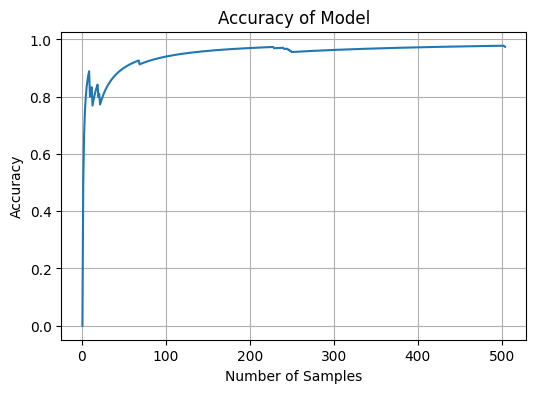

In [ ]:
# Plot accuracy on a graph
plt.figure(figsize=(6, 4))
sns.lineplot(x=range(1, total_samples + 1), y=accuracy_plot)
plt.title('Accuracy of Model')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

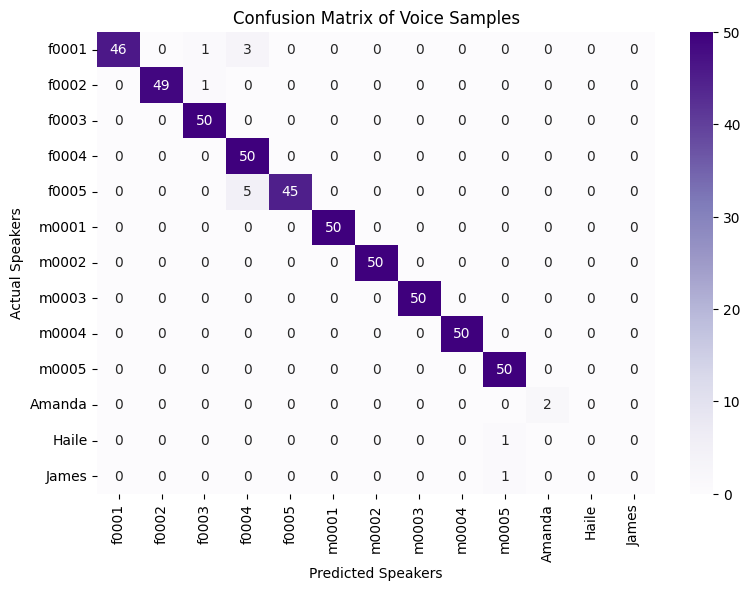

In [ ]:
# Create confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=['f0001', 'f0002', 'f0003', 'f0004', 'f0005', 'm0001', 'm0002', 'm0003', 'm0004', 'm0005', "Amanda", "Haile", "James"])

# Plot confusion matrix
plt.figure(figsize=(9, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['f0001', 'f0002', 'f0003', 'f0004', 'f0005', 'm0001', 'm0002', 'm0003', 'm0004', 'm0005', "Amanda", "Haile", "James"],
            yticklabels=['f0001', 'f0002', 'f0003', 'f0004', 'f0005', 'm0001', 'm0002', 'm0003', 'm0004', 'm0005', "Amanda", "Haile", "James"])
plt.xlabel('Predicted Speakers')
plt.ylabel('Actual Speakers')
plt.title('Confusion Matrix of Voice Samples')
plt.show()

#Results

**10 Speakers (5 female and 5 male) -> 100 wav files per speaker (50 for training, 50 for testing)**

Total Inputs: 500

Accepted Inputs: 477

Rejected Inputs: 23

Accuracy: 95.40%